# fmdtools Tutorial

This tutorial notebook will show some of the basic commands needed to perform resilience analysis in fmdtools.

For some context, it may be helpful to look through the accompanying presentation. This notebook uses the model defined in `ex_pump.py`. In this notebook, we will:

- Load an environment and model
- Simulate the system in nominal and faulty scenarios
- Visualize and quantify the results

## 1.) Loading the environment and model

To load the `fmdtools` environment, we have to import it. 

Since we're in a subfolder of the repository, we need to add the fmdtools folder to the system path. (This would be unnecessary if we installed using `pip`)

In [1]:
#First, import the fault propogation library as well as the model
#since the package is in a parallel location to examples...
import sys
# for use in development - makes sure git version is used instead of pip-installed version
paths = sys.path
if paths[1]!='../':
    sys.path=[sys.path[0]] + ['../'] + paths

There are a number of different syntaxes for importing modules. Because of the long names of the module trees, it is often helpful to load the modules individually and abbreviate (e.g. ``import fmdtools.faultsim.propagate as propagate``). Below, import the propagate `fmdtools.faultsim.propagate` and `fmdtools.resultdisp` modules, as well as the `SampleApproach` from `fmdtools.modeldef`

In [2]:
import fmdtools.faultsim.propagate as propagate
import fmdtools.resultdisp as rd
from fmdtools.modeldef import SampleApproach

Now, import the Pump class defined in the ex_pump module.

In [3]:
from ex_pump import Pump

We can then use that to instantiate a model object. See:

In [4]:
mdl = Pump()

To get started, it can be helpful to view some of the aspects of the model. Try `dir(mdl)`, `mdl.fxns`, `mdl.flows`, `mdl.graph`, etc.

In [5]:
mdl.fxns

{'ImportEE': ImportEE ImportEE function: ({}, {'nom'}),
 'ImportWater': ImportWater ImportWater function: ({}, {'nom'}),
 'ImportSignal': ImportSignal ImportSig function: ({}, {'nom'}),
 'MoveWater': MoveWater MoveWat function: ({'eff': 1.0}, {'nom'}),
 'ExportWater': ExportWater ExportWater function: ({}, {'nom'})}

We can also view the run order to see how the model will be simulated.

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1fe31aeaf88>)

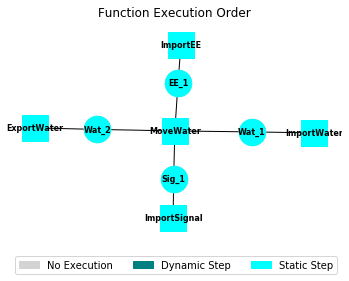

In [6]:
rd.graph.exec_order(mdl)

As shown, because all of the methods were defined as generic behaviors, they are each run in the static propagation step. No order is shown in the static step because the static propagation step iterates between model functions until the values have converged. Nevertheless, one can view the initial static order using:

In [7]:
mdl.staticfxns

OrderedSet(['ImportEE', 'ImportWater', 'ImportSignal', 'MoveWater', 'ExportWater'])

and the dynamic step order (if there was one):

In [8]:
mdl.dynamicfxns

OrderedSet()

We can also instantiate this model with different model parameters. By default, this model gets 
`params={'cost':{'repair', 'water'}, 'delay':10, 'units':'hrs'}` but we can pass any set of costs that is a subset of `{'repair', 'water', 'water_exp', 'ee'}` and any int `delay` parameter.

In [9]:
mdl2 = Pump(params={'cost':{'repair', 'water', 'ee'}, 'delay':20, 'units':'hrs'})

# 2.) and 3.) Simulate and visualize the results!

Now, we will use the methods in `propagate` and the visualization modules in `rd` to simulate the model and visualize the results.

### 2a.) Simulate nominal
To simulate the model in the nominal scenario, use the `propagate.nominal` method.

In [10]:
endresults_nominal, resgraph_nominal, mdlhist_nominal=propagate.nominal(mdl, track="all")

What do the results look like? Explore results structures.

In [11]:
endresults_nominal

{'faults': {},
 'classification': {'rate': 1.0, 'cost': 0.0, 'expected cost': 0.0}}

### 2b.) Visualize nominal model
First, we can show the model graph using `rd.graph.show` to see that it was set up correctly. We can do this both on the model graph itself `mdl.graph` and the results of the nominal run `resgraph_nominal` to verify both are fault-free.

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1fe34833ac8>)

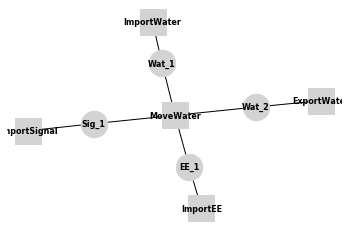

In [13]:
rd.graph.show(mdl)

We can also view the flow values of the model using ''rd.plot.mdlhistvals''. It may be helpful to only view flows of interest.

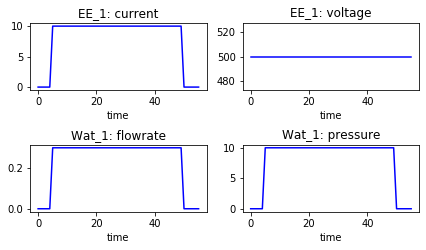

In [14]:
fig = rd.plot.mdlhistvals(mdlhist_nominal, fxnflowvals={'Wat_1':['flowrate','pressure'], 'EE_1':['voltage', 'current']}, returnfig=True)

Note: for quick access to the syntax and options for these methods, type the `?method` or `help(method)` in the terminal. For example `?rd.plot.mdlhistvals`

In [15]:
?rd.plot.mdlhistvals

### 2b.) Simulate a fault mode
To simulate the model in the nominal scenario, use the `propagate.one_fault` method. The set of possible faults is defined in the function definitions in `ex_pump.py`, and we can propagate a fault at any time in the operational interval (0-55 seconds).

In [16]:
endresults_fault, resgraph_fault, mdlhist_fault=propagate.one_fault(mdl, 'MoveWater', 'short', time=10)

We can also view the results for from this. In this case `mdlhist` gives a history of results for both the nominal and faulty runs.

In [17]:
endresults_fault

{'flows': {'EE_1': {'voltage': 0.0}},
 'faults': {'ImportEE': ['no_v'], 'MoveWater': ['short']},
 'classification': {'rate': 0.00055,
  'cost': 29000.000000000007,
  'expected cost': 1595000.0000000005}}

In [18]:
mdlhist_fault.keys()

dict_keys(['nominal', 'faulty'])

### 3b.) Visualize fault model states
`rd.plot.mdlhistvals` also works for a mdlhists given from `propagate.one_fault`. We can view these results below. As shown, the function will give the nominal result in a blue dotted line and the faulty result in a red line.

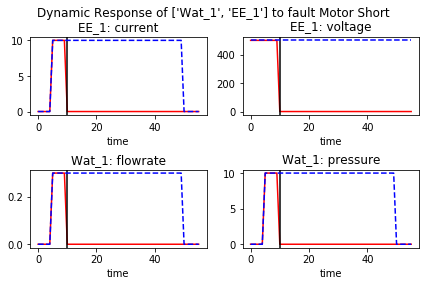

In [19]:
fig = rd.plot.mdlhistvals(mdlhist_fault, fault='Motor Short', time=10, legend=False, fxnflowvals={'Wat_1':['flowrate','pressure'], 'EE_1':['voltage', 'current']}, returnfig=True)

We can also view this result graph using 'rd.graph.show'. In this case, it shows the state of the model at the final time-step of the model run. Thus, while the `EE_1` flow is shown in orange (because it is off-nominal), the Water flows are not, because they have the same state at the final time-step.

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1fe34b80888>)

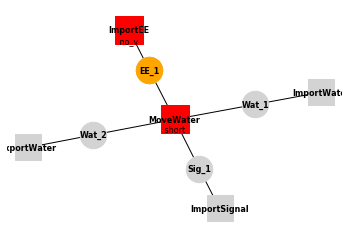

In [20]:
rd.graph.show(resgraph_fault)

If we want to view the graph at another time-step, we can use 'rd.process.hist' and 'rd.graph.result_from' to first process the model states into results which can be visualized and then map that onto a graph view at a given time.

In [21]:
reshist_fault, b, c = rd.process.hist(mdlhist_fault)

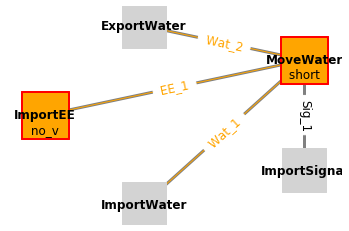

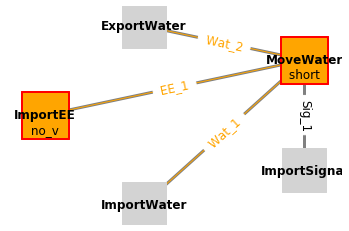

In [22]:
rd.graph.result_from(mdl, reshist_fault, 20, gtype='normal')

### 4a.) Simulate set of fault modes

To simulate the set of fault modes, we first choose a `SampleApproach`. For simplicity, we can choose default parameters at first.

In [23]:
app = SampleApproach(mdl)

In [24]:
endclasses_app, mdlhists_app = propagate.approach(mdl, app)

SCENARIOS COMPLETE: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 274.89it/s]


It can be helpful to view what these results look like--a dictionary of faults injected at particular times with their respective results dictionaries.

In [25]:
endclasses_app

{'ImportEE no_v, t=27': {'rate': 0.0003600000000000001,
  'cost': 15174.999999999998,
  'expected cost': 546300.0},
 'ImportEE inf_v, t=27': {'rate': 9.000000000000002e-05,
  'cost': 20175.0,
  'expected cost': 181575.00000000003},
 'ImportWater no_wat, t=27': {'rate': 0.00015,
  'cost': 6174.999999999998,
  'expected cost': 92624.99999999996},
 'ImportSignal no_sig, t=27': {'rate': 1.2857142857142856e-05,
  'cost': 15174.999999999998,
  'expected cost': 19510.714285714283},
 'MoveWater mech_break, t=27': {'rate': 0.00023142857142857142,
  'cost': 10174.999999999998,
  'expected cost': 235478.5714285714},
 'MoveWater short, t=27': {'rate': 0.00012857142857142858,
  'cost': 25175.0,
  'expected cost': 323678.5714285714},
 'ExportWater block, t=27': {'rate': 0.00012857142857142858,
  'cost': 15150.25,
  'expected cost': 194788.92857142858},
 'ImportWater no_wat, t=2': {'rate': 1.6666666666666667e-05,
  'cost': 11125.000000000007,
  'expected cost': 18541.66666666668},
 'ImportSignal no_s

It can be helpful to explore different approach parameters (e.g. focussing on single faults, different numbers of sample points, etc)

In [26]:
app2 = SampleApproach(mdl, faults=[('MoveWater', 'short')])

In [27]:
app2.list_modes()

[('MoveWater', 'short')]

There are a number of different ways to sample the scenarios in the approach:

In [28]:
app3 = SampleApproach(mdl, defaultsamp={'samp':'evenspacing', 'numpts':5})

In [29]:
app3.times

[0, 1, 2, 3, 4, 12, 20, 27, 34, 42, 50, 51, 52, 53, 54]

### 4b.) Visualize set of fault modes

Using this fault approach, we can now make an FMEA-like analyses of the different fault modes. `rd.tabulate.summfmea` organizes endclasses into a table for each fault.

In [30]:
summary_fmea = rd.tabulate.summfmea(endclasses_app, app)
summary_fmea

rate          cost  expected cost
ImportEE     no_v        0.000360  15175.000000  546300.000000
             inf_v       0.000090  20175.000000  181575.000000
ImportWater  no_wat      0.000183   6100.000000  112833.333333
ImportSignal no_sig      0.000016  15100.000000   25251.785714
MoveWater    mech_break  0.000236  10100.000000  239791.071429
             short       0.000164  21766.666667  402517.857143
ExportWater  block       0.000164  13416.833333  245003.750000

We can also use `rd.tabulatefullmea` with the processed results histories to get a better picture of which flows and functions degrade in each scenario

In [31]:
reshist_fault, b, summaries = rd.process.hists(mdlhists_app)

In [32]:
rd.tabulate.fullfmea(endclasses_app, summaries)

,degraded functions,degraded flows,rate,cost,expected cost
"ImportEE no_v, t=27",[ImportEE],"[EE_1, Wat_1, Wat_2]",0.00036,15175,546300
"ImportEE inf_v, t=27",[ImportEE],"[EE_1, Wat_1, Wat_2]",9e-05,20175,181575
"ImportWater no_wat, t=27",[ImportWater],"[EE_1, Wat_1, Wat_2]",0.00015,6175,92625
"ImportSignal no_sig, t=27",[ImportSignal],"[EE_1, Sig_1, Wat_1, Wat_2]",1.28571e-05,15175,19510.7
"MoveWater mech_break, t=27",[MoveWater],"[EE_1, Wat_1, Wat_2]",0.000231429,10175,235479
"MoveWater short, t=27","[ImportEE, MoveWater]","[EE_1, Wat_1, Wat_2]",0.000128571,25175,323679
"ExportWater block, t=27","[MoveWater, ExportWater]","[EE_1, Wat_1, Wat_2]",0.000128571,15150.2,194789
"ImportWater no_wat, t=2",[ImportWater],"[EE_1, Wat_1, Wat_2]",1.66667e-05,11125,18541.7
"ImportSignal no_sig, t=2",[ImportSignal],"[EE_1, Sig_1, Wat_1, Wat_2]",2.14286e-06,20125,4312.5
"MoveWater mech_break, t=2",[MoveWater],"[EE_1, Wat_1, Wat_2]",2.14286e-06,15125,3241.07
